# Pytorch-VDSR

In [2]:
# Load the package you are going to use
import torch
from torch.autograd import Variable
from PIL import Image
import numpy as np
import time, math
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# Load the pretrained model
model = torch.load("checkpoint/VDSR_Adam_epoch_38.pth")["model"]

In [29]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("Set5/butterfly_GT_scale_4.bmp").convert("RGB")

In [30]:
# Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
im_b_ycbcr = np.array(im_b.convert("YCbCr"))
im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
im_b_y = im_b_ycbcr[:,:,0].astype(float)

In [31]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [32]:
# Calculate the PNSR for bicubic interpolation
# For best PSNR score, you will have to use Matlab for color space transformation, 
# since it is different from Python's implementation
psnr_bicubic = PSNR(im_gt_y, im_b_y)
print('psnr for bicubic is {}dB'.format(psnr_bicubic))

psnr for bicubic is 20.824648960041763dB


In [33]:
# Prepare for the input, a pytorch tensor
im_input = im_b_y/255.
im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])

In [34]:
# Let's try the network feedforward in cpu mode
model = model.cpu()
out = model(im_input)

In [35]:
# Get the output image
out = out.cpu()
im_h_y = out.data[0].numpy().astype(np.float32)
im_h_y = im_h_y * 255.
im_h_y[im_h_y < 0] = 0
im_h_y[im_h_y > 255.] = 255.
im_h_y = im_h_y[0,:,:]

In [36]:
# Calculate the PNSR for vdsr prediction
psnr_predicted = PSNR(im_gt_y, im_h_y)
print('psnr for vdsr is {}dB'.format(psnr_predicted))

psnr for vdsr is 23.040550458529317dB


In [37]:
# Calculate the PNSR different between bicubic interpolation and vdsr prediction
print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))

PSNR improvement is 2.215901498487554dB


In [38]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [39]:
# Colorize the grey-level image and convert into RGB mode
im_h = colorize(im_h_y, im_b_ycbcr)
im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")

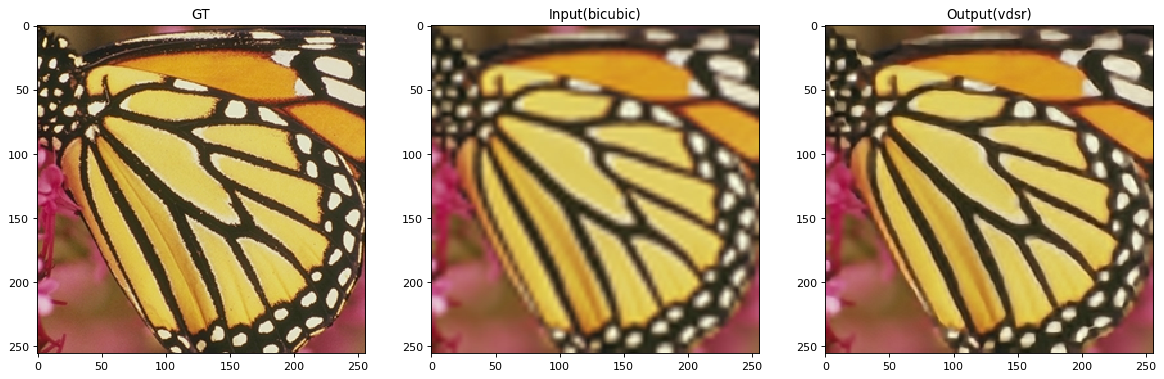

In [40]:
# Result visualization
fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(im_gt)
ax.set_title("GT")

ax = plt.subplot("132")
ax.imshow(im_b)
ax.set_title("Input(bicubic)")

ax = plt.subplot("133")
ax.imshow(im_h)
ax.set_title("Output(vdsr)")
plt.show()